![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Welcome to MuJoCo Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/welcome_to_the_playground.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

Welcome to MuJoCo Playground, we're excited to meet you! MuJoCo Playground contains a comprehensive suite of environments for reinforcement learning and robotics research. In this notebook, we'll give a tour of [DM Control Suite](https://github.com/google-deepmind/dm_control/tree/main/dm_control/suite) environments that were ported to run on GPU via [MJX](https://mujoco.readthedocs.io/en/stable/mjx.html).

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [ ]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

/tmp/ipykernel_14125/1100621786.py:3: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


Thu Jul  3 12:03:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8              6W /  285W |     221MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# @title Import packages for plotting and creating graphics
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
# print("Installing mediapy:")
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [ ]:
#@title Install MuJoCo Playground
!pip install playground

# Intro

MuJoCo Playground contains environments for DM Control Suite, Robotic Locomotion, and Robotic Manipulation. You can load any of these environments via the environment registry:

In [4]:
from mujoco_playground import registry
env = registry.load('CartpoleBalance')
env

Each environment is also associated with an environment config, which can be overriden if so desired. Let's also load the config:

In [5]:
env_cfg = registry.get_default_config('CartpoleBalance')
env_cfg

action_repeat: 1
ctrl_dt: 0.01
episode_length: 1000
sim_dt: 0.01
vision: false
vision_config:
  enabled_geom_groups:
  - 0
  - 1
  - 2
  gpu_id: 0
  history: 3
  render_batch_size: 512
  render_height: 64
  render_width: 64
  use_rasterizer: false

Notice that the environment config contains `sim_dt` and `ctrl_dt`. Each simulation step runs with a timestep of `sim_dt`. `ctrl_dt` determines how much time passes by for each `env.step`. Thus every `env.step` will step the simulation `ctrl_dt / sim_dt` times.

Other parameters worth noting are `vision_config`, which we discuss more about in the vision-based notebooks! For now, we'll stick to privileged observations.

# Rollout

Let's now do a simple rollout. This follows closely with the [MJX tutorial notebook](https://colab.sandbox.google.com/github/google-deepmind/mujoco/blob/main/mjx/tutorial.ipynb). If you're familiar with MJX, this should be familiar; otherwise feel free to checkout out the MJX tutorial first!

In [6]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [7]:
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

f = 0.5
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            state.data.time * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.array(action)
  state = jit_step(state, action)
  rollout.append(state)

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 1900.49it/s]


If you're running the notebook with a GPU instance (which you should), notice that the environment runs and lives on the device! That of course means we can do some large-batch RL on the GPU.

In [8]:
state.obs.device

CudaDevice(id=0)

# RL

We'll use [brax](https://github.com/google/brax) to train some RL policies, but we show examples with [RSL-RL](https://github.com/google-deepmind/mujoco_playground/tree/main/learning/train_rsl_rl.py) in the main repo via [`python train_rsl_rl.py`](). We encourage `pytorch` users to take a look!

For now we'll go ahead with a brax PPO example.



MuJoCo Playground comes with a set of hyper-parameters for all available environments via `mujoco_playground.config`. A selection of environments contain configs for RSL-RL and for vision-based brax PPO. Let's load the brax PPO config for CartpoleBalance!

In [9]:
from mujoco_playground.config import dm_control_suite_params
ppo_params = dm_control_suite_params.brax_ppo_config('CartpoleBalance')
ppo_params

action_repeat: 1
batch_size: 1024
discounting: 0.995
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.001
normalize_observations: true
num_envs: 2048
num_evals: 10
num_minibatches: 32
num_timesteps: 60000000
num_updates_per_batch: 16
reward_scaling: 10.0
unroll_length: 30

And let's of course train a policy!

### PPO

In [10]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

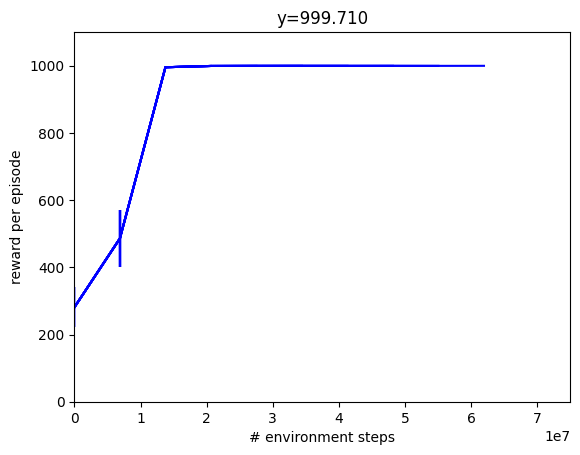

time to jit: 0:00:29.157317
time to train: 0:02:11.083998


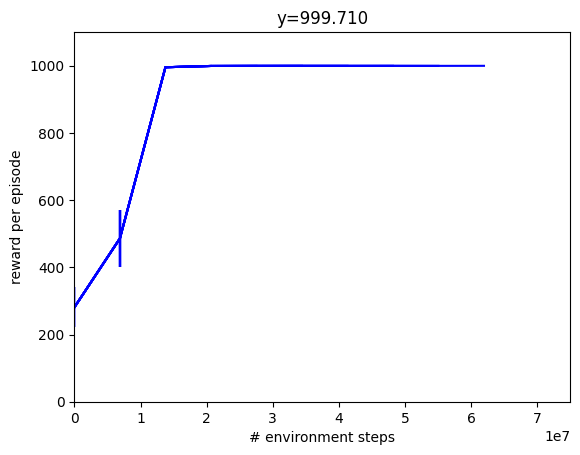

In [11]:
from mujoco_playground import wrapper

make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

If you're familiar with brax, you'll notice that we provided a custom wrapper to the `train_fn`. That's because MuJoCo Playground environments are not compatible with the vanilla brax wrappers. For RSL-RL, we ship wrappers in [`wrapper_torch.py`](https://github.com/google-deepmind/mujoco_playground/tree/main/mujoco_playground/_src/wrapper_torch.py).

## Visualize Rollout

In [12]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [13]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 1471.98it/s]


# DM Control Suite - Take a spin!

Feel free to now take a spin on any of the DM Control Suite environments! The world is your oyster.

In [14]:
env_name = "ReacherEasy"  # @param ["AcrobotSwingup", "AcrobotSwingupSparse", "BallInCup", "CartpoleBalance", "CartpoleBalanceSparse", "CartpoleSwingup", "CartpoleSwingupSparse", "CheetahRun", "FingerSpin", "FingerTurnEasy", "FingerTurnHard", "FishSwim", "HopperHop", "HopperStand", "HumanoidStand", "HumanoidWalk", "HumanoidRun", "PendulumSwingup", "PointMass", "ReacherEasy", "ReacherHard", "SwimmerSwimmer6", "WalkerRun", "WalkerStand", "WalkerWalk"]
CAMERAS = {
    "AcrobotSwingup": "fixed",
    "AcrobotSwingupSparse": "fixed",
    "BallInCup": "cam0",
    "CartpoleBalance": "fixed",
    "CartpoleBalanceSparse": "fixed",
    "CartpoleSwingup": "fixed",
    "CartpoleSwingupSparse": "fixed",
    "CheetahRun": "side",
    "FingerSpin": "cam0",
    "FingerTurnEasy": "cam0",
    "FingerTurnHard": "cam0",
    "FishSwim": "fixed_top",
    "HopperHop": "cam0",
    "HopperStand": "cam0",
    "HumanoidStand": "side",
    "HumanoidWalk": "side",
    "HumanoidRun": "side",
    "PendulumSwingup": "fixed",
    "PointMass": "cam0",
    "ReacherEasy": "fixed",
    "ReacherHard": "fixed",
    "SwimmerSwimmer6": "tracking1",
    "WalkerRun": "side",
    "WalkerWalk": "side",
    "WalkerStand": "side",
}
camera_name = CAMERAS[env_name]

In [15]:
env_cfg = registry.get_default_config(env_name)
env = registry.load(env_name, config=env_cfg)

## Visualize the environment

In [16]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [17]:
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

f = 0.5
for i in range(env_cfg.episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            state.data.time * 2 * jp.pi * f + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.array(action)
  state = jit_step(state, action)
  rollout.append(state)

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 1781.93it/s]


## Train

In [21]:
from mujoco_playground.config import dm_control_suite_params

ppo_params = dm_control_suite_params.brax_ppo_config(env_name)
sac_params = dm_control_suite_params.brax_sac_config(env_name)
print(ppo_params)

action_repeat: 1
batch_size: 1024
discounting: 0.995
entropy_cost: 0.01
episode_length: 1000
learning_rate: 0.001
normalize_observations: true
num_envs: 2048
num_evals: 10
num_minibatches: 32
num_timesteps: 60000000
num_updates_per_batch: 16
reward_scaling: 10.0
unroll_length: 30



### PPO

In [19]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

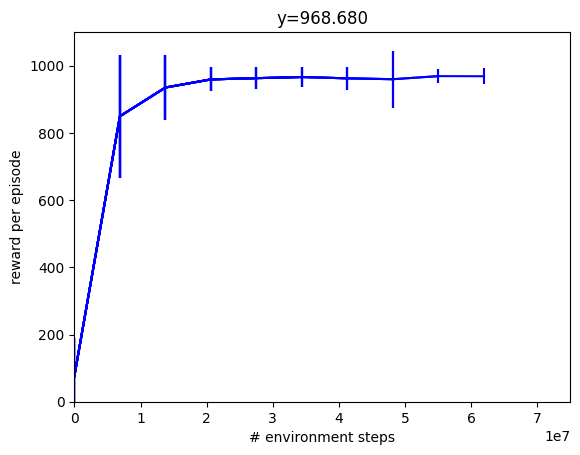

time to jit: 0:00:19.110548
time to train: 0:02:34.852320


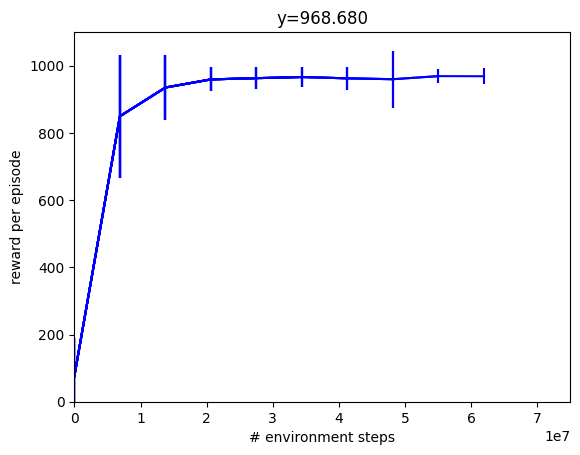

In [20]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
# trying multiple runs

num_seeds = 32
rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, num_seeds)
train_vjit = jax.jit(jax.vmap(make_train(config)))
t0 = time.time()
outs = jax.block_until_ready(train_vjit(rngs))
print(f"time: {time.time() - t0:.2f} s")

In [22]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [24]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 10

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

100%|████████████████████████████████████████████████████████████████████████████| 10010/10010 [00:05<00:00, 1678.62it/s]


### SAC

In [ ]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, sac_params["num_timesteps"] * 1.25])
  plt.ylim([0, 1100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

sac_training_params = dict(sac_params)
network_factory = sac_networks.make_sac_networks
if "network_factory" in sac_params:
  del sac_training_params["network_factory"]
  network_factory = functools.partial(
      sac_networks.make_sac_networks,
      **sac_params.network_factory
  )

train_fn = functools.partial(
    sac.train, **dict(sac_training_params),
    network_factory=network_factory,
    progress_fn=progress
)

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(0)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

🙌 See you soon!